In [25]:
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error
import joblib

In [26]:
df = pd.read_csv('../data/cubic_zirconia.csv', index_col = 0)
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
1,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
2,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
3,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
4,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
5,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


In [27]:
df.shape

(26967, 10)

In [28]:
df.isna().sum()

carat        0
cut          0
color        0
clarity      0
depth      697
table        0
x            0
y            0
z            0
price        0
dtype: int64

In [29]:
df = df.loc[~df.depth.isnull()]
df.shape

(26270, 10)

<Axes: >

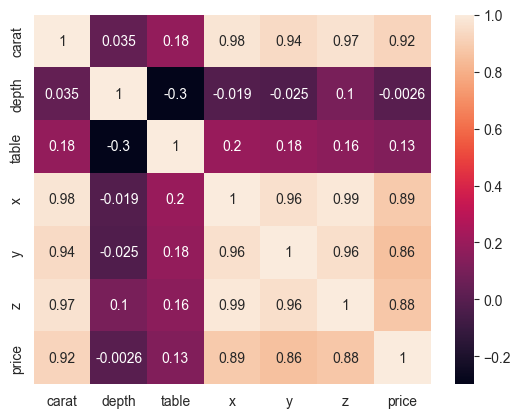

In [30]:
sns.heatmap(df[['carat', 'depth', 'table', 'x', 'y', 'z', 'price']].corr(), annot=True)

x, y & z have high correlation between each other and with carat. It is better to drop them because they are redundant

In [31]:
df = df.drop(columns=['x', 'y', 'z',  ])
df.head()

,carat,cut,color,clarity,depth,table,price
1,0.30,Ideal,E,SI1,62.1,58.0,499
2,0.33,Premium,G,IF,60.8,58.0,984
3,0.90,Very Good,E,VVS2,62.2,60.0,6289
4,0.42,Ideal,F,VS1,61.6,56.0,1082
5,0.31,Ideal,F,VVS1,60.4,59.0,779


In [32]:
df_encoded = pd.get_dummies(df, columns=['cut','color', 'clarity' ])

We drop the price column and save it in a variable as this is the column we want to predict

In [33]:
y = df.price
df = df.drop(columns=['price', 'cut','color', 'clarity'])
df_encoded = df_encoded.drop(columns=['price'])

We also have 2 different testing data, 1 with the categories and one without it to see how the results differ from each other

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.2, random_state = 64)

In [35]:
scaler = StandardScaler()

In [36]:
X_norm = scaler.fit_transform(X_train)

In [37]:
X_norm_test = scaler.transform(X_test)

# Without categories

## SVR

In [38]:
svr = SVR()

In [39]:
svr.fit(X_norm, y_train)

SVR()

In [40]:
y_pred = svr.predict(X_norm_test)

In [41]:
svr_without_categories = [mean_squared_error(y_test,y_pred), r2_score(y_test,y_pred)]
svr_without_categories[0] #mse

9908086.953591311

In [42]:
svr_without_categories[1] #r2 sore

0.3705148153514829

In [43]:
joblib.dump(svr, '../models/svr_no_cat.z')

['../models/svr_no_cat.z']

## Linear regression

In [44]:
lr = LinearRegression()

In [45]:
lr.fit(X_norm, y_train)

LinearRegression()

In [46]:
y_pred = lr.predict(X_norm_test)

In [47]:
lr_without_categories = [mean_squared_error(y_test,y_pred), r2_score(y_test,y_pred)]
lr_without_categories[0] #mse

2382599.8643293898

In [48]:
lr_without_categories[1] #r2 sore

0.8486275582192693

In [49]:
joblib.dump(lr, '../models/lr_no_cat.z')

['../models/lr_no_cat.z']

## Random Forest

In [50]:
rf = RandomForestRegressor(random_state = 0)

In [51]:
rf.fit(X_norm, y_train)

RandomForestRegressor(random_state=0)

In [52]:
y_pred = rf.predict(X_norm_test)

In [53]:
rf_without_categories = [mean_squared_error(y_test,y_pred), r2_score(y_test,y_pred)]
rf_without_categories[0] #mse

2220347.903861985

In [54]:
rf_without_categories[1] #r2 sore

0.858935825170579

In [55]:
joblib.dump(rf, '../models/rf_no_cat.z')

['../models/rf_no_cat.z']

# With categories

## SVR

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size = 0.2, random_state = 64)

In [57]:
X_norm = scaler.fit_transform(X_train)

In [58]:
X_norm_test = scaler.transform(X_test)

In [59]:
svr.fit(X_norm, y_train)

SVR()

In [60]:
y_pred = svr.predict(X_norm_test)

In [61]:
svr_with_categories = [mean_squared_error(y_test,y_pred), r2_score(y_test,y_pred)]
svr_with_categories[0] #mse

16223554.533747029

In [62]:
svr_with_categories[1] #r2 sore

-0.03072240576465579

In [63]:
joblib.dump(svr, '../models/svr_with_cat.z')

['../models/svr_with_cat.z']

## Linear Regression

In [64]:
lr.fit(X_norm, y_train)

LinearRegression()

In [65]:
y_pred = lr.predict(X_norm_test)

In [66]:
lr_with_categories = [mean_squared_error(y_test,y_pred), r2_score(y_test,y_pred)]
lr_with_categories[0] #mse

1352235.1735824943

In [67]:
lr_with_categories[1] #r2 sore

0.9140891665648672

In [68]:
joblib.dump(lr, '../models/lr_with_cat.z')

['../models/lr_with_cat.z']

## Random Forest

In [69]:
rf.fit(X_norm, y_train)

RandomForestRegressor(random_state=0)

In [70]:
y_pred = rf.predict(X_norm_test)

In [71]:
rf_with_categories = [mean_squared_error(y_test,y_pred), r2_score(y_test,y_pred)]
rf_with_categories[0] #mse

351534.7956183325

In [72]:
rf_with_categories[1] #r2 sore

0.9776661280056714

In [73]:
joblib.dump(lr, '../models/lr_with_cat.z')

['../models/lr_with_cat.z']

# Comparison

Our main objective is to lower the mean squared error and to increase the R2 score, we'll now compare the results of the different models training with and without the categories.

## MSE

In [74]:
[svr_with_categories[0] - svr_without_categories[0],  lr_with_categories[0] - lr_without_categories[0], rf_with_categories[0] - rf_without_categories[0]]

[6315467.580155717, -1030364.6907468955, -1868813.1082436526]

Only with SVR the MSE was worse when the categorical data was included (with one-hot encoding). The other 2 models (linear regression and random forest) performed better when the extra (categorical) data was included.

## R2 Score

In [75]:
[svr_with_categories[1] - svr_without_categories[1],  lr_with_categories[1] - lr_without_categories[1], rf_with_categories[1] - rf_without_categories[1]]

[-0.4012372211161387, 0.06546160834559789, 0.11873030283509245]

Similar to the MSE results, SVR performed worse when the training data included the encoded categorical data. We can see that the increase is significant in linear regression (an increase of 6.5%) and even more in Random Forest (an increase of 11.9%).

# Conclusions

- The random forest model outperformed both the linear regressor and the SVR with and without the encoded categorical data.
- Overall we can say that the inclusion of categorical data with one-hot encoding generated better predictions for the models, specially for Random Forests, however this was not the case with SVR.
- SVR had really bad results, this may be attributed to overlap in data or to outliers in the data, data cleaning should help increasing the performance of this model the most.
- We can see that Random Forest is a really robust model that can give good results without the need of a lot of data cleaning.
- Data cleaning should be done for an increase in performance in the models, specially removal of outliers, but the less benefited from these cleaning would be the Random forest model, although every increase in performance is welcome specially when it does not come with an increase on computational complexity.